In [ ]:
# !pip install -r requirements.txt

In [1]:
from easyocr import Reader
from pytube import YouTube

import time
import pandas as pd
import cv2
import whisper
import pickle
import joblib
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

c:\Users\minsu\anaconda3\envs\deeplearning\lib\site-packages\whisper\timing.py:58: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def backtrace(trace: np.ndarray):


### 1. CV2

In [2]:
langs = ['ko', 'en']
easyocr_CV2 = Reader(lang_list=langs, gpu=False)

whisper_model = whisper.load_model("base")

Using CPU. Note: This module is much faster with a GPU.


In [3]:
url = 'https://www.youtube.com/watch?v=bGcVkNP1tPs&t=2s&ab_channel=1%EB%B6%84%EB%AF%B8%EB%A7%8C'
yt = YouTube(url)
video = yt.streams.get_highest_resolution()
audio = yt.streams.filter(only_audio=True).first()

In [17]:
# easyocr으로 Text 추출
cap = cv2.VideoCapture(video.url)
fps = cap.get(cv2.CAP_PROP_FPS)
frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT) # 프레임 개수
print("fps :", fps)
print("frame_count :", frame_count)
easyocr_results = pd.DataFrame(columns=["bbox", "text", "conf", "time"])
images = []
time_CV2 = []
start_time = time.time()
for _ in tqdm(range(int(frame_count))):
    frame_pos = cap.get(cv2.CAP_PROP_POS_FRAMES) # 현재 프레임
    success, frame = cap.read()
    if not success:
        print('not success frame :', frame_pos)
        print('not success time :', frame_pos / fps)
        print('not success ... break')
        break
    if frame_pos % fps != 0: # 1초에 한 장씩
        continue
    images.append(frame)
    result = pd.DataFrame(easyocr_CV2.readtext(frame, detail=1), columns=['bbox', 'text', 'conf'])
    result['time'] = frame_pos / fps 
    easyocr_results = pd.concat([easyocr_results, result], ignore_index=True)
    # if count // fps >= 5: # 5초까지
    #     break
    time_CV2.append(time.time() - start_time)
end_time = time.time()

print("time :", end_time - start_time)

fps : 30.0
frame_count : 3594.0


 84%|████████▍ | 3021/3594 [04:40<00:53, 10.77it/s]

not success frame : 3021.0
not success time : 100.7
not success ... break
time : 280.4164478778839


In [18]:
easyocr_results

,bbox,text,conf,time
0,"[[497, 254], [787, 254], [787, 340], [497, 340]]",자 오늘은,0.999160,0.0
1,"[[253, 252], [1027, 252], [1027, 343], [253, 3...",지금 전국민이 훈린에 빠진,0.502869,1.0
2,"[[463, 251], [816, 251], [816, 342], [463, 342]]",우회전 관련,0.731145,2.0
3,"[[326, 252], [953, 252], [953, 341], [326, 341]]",(최종정리 영상 인데요,0.747477,3.0
4,"[[268, 204], [342, 204], [342, 236], [268, 236]]",막가각,0.999576,4.0
...,...,...,...,...
145,"[[23, 95], [993, 95], [993, 203], [23, 203]]",돼리에세다 일시정지하고선,0.425776,96.0
146,"[[25, 95], [905, 95], [905, 203], [25, 203]]",라느데 맞다라고 보고서움,0.121264,97.0
147,"[[28, 96], [904, 96], [904, 200], [28, 200]]",가능게 맞다라고 보고서움,0.134659,98.0
148,"[[27, 95], [759, 95], [759, 203], [27, 203]]",이렇제 매정올 합h락,0.170258,99.0


In [19]:
easyocr_model = joblib.load("easyocr_model.pkl")

In [20]:
import subprocess
import re
import numpy as np

easyocr_ffmpeg = pd.DataFrame(columns=["bbox", "text", "conf", "time"])

# fps 추출
ffmpeg_cmd = ['ffmpeg', '-i', video.url, '-f', 'null', '-']
output = subprocess.check_output(ffmpeg_cmd, stderr=subprocess.STDOUT).decode()

fps_match = re.search(r"\b(\d+\.?\d*)\sfps\b", output)
fps = float(fps_match.group(1)) if fps_match else None
        
# frame_count 추출
command = ['ffprobe', '-v', 'error', '-count_frames', '-select_streams', 'v:0', '-show_entries',
               'stream=nb_read_frames', '-of', 'default=nokey=1:noprint_wrappers=1', video.url]
output = subprocess.check_output(command).decode().strip()
frame_count = int(output) if output.isdigit() else None
        
print("fps :", fps)
print("frame_count :", frame_count)
        
        
# 이미지의 width, height 구해야함.
wh_command = ['ffprobe', '-v', 'error', '-select_streams', 'v:0', '-show_entries', 'stream=width,height',
               '-of', 'csv=s=x:p=0', video.url]
output = subprocess.check_output(wh_command).decode().strip()
width, height = map(int, output.split('x'))
            
ffmpeg_a = ['ffmpeg', '-i', video.url, '-vf', 'select=not(mod(n\\,{0}))'.format(fps), '-vsync', 'vfr',
                  '-f', 'image2pipe', '-pix_fmt', 'rgb24', '-vcodec', 'rawvideo', '-']
            
# ffmpeg pipeline구성
ffmpeg_pipe = subprocess.Popen(ffmpeg_a, stdout=subprocess.PIPE, bufsize=10**8)
        
frames = []
time_ffmepg = []
s = time.time()
frame_pos = 0
#for i in tqdm(range(self.frame_count)):
while True:
    # 파이프라인에서 프레임 데이터 읽기
    raw_frame = ffmpeg_pipe.stdout.read(height * width * 3)
    if not raw_frame:
        break
            
    frame = np.frombuffer(raw_frame, np.uint8).reshape((height, width, 3))
    frames.append(frame)
            
    result = pd.DataFrame(easyocr_model.readtext(frame, detail=1), columns=[
                'bbox', 'text', 'conf'
            ])
    result['time'] = frame_pos / fps
    easyocr_ffmpeg = pd.concat([easyocr_ffmpeg, result], ignore_index=True)
    frame_pos += 1
    time_ffmepg.append(time.time() - s)
        
ffmpeg_pipe.stdout.close()
ffmpeg_pipe.wait()
        
        # 시간을 재기 위해,어쩔수 없이 result를 while문에 구성하였음.
        # while문 빼고, 아랫 하단 for문에서 돌리면 시간이 반으로 줄어듬.(이유: 배치파일, 병렬처리 때문인것 같음)
        # for i in tqdm(range(len(frames))):  
            # result = pd.DataFrame(self.easyocr_model.readtext(frame, detail=1), columns=[
            #     'bbox', 'text', 'conf'
            # ])
            # # result['time'] = frame_pos / self.fps
            
            # self.easyocr_results = pd.concat([self.easyocr_results, result], ignore_index=True)
            # frame_pos += 1
e = time.time()
print("time :", e - s)

fps : 30.0
frame_count : 3594
time : 28.975933074951172


In [21]:
easyocr_ffmpeg

,bbox,text,conf,time
0,"[[497, 254], [787, 254], [787, 340], [497, 340]]",자 오늘은,0.998882,0.000000
1,"[[253, 251], [1029, 251], [1029, 343], [253, 3...",지금 전국민이 혼린에 빠진,0.600571,0.033333
2,"[[462, 252], [815, 252], [815, 341], [462, 341]]",우회전 관련,0.995620,0.066667
3,"[[327, 253], [953, 253], [953, 341], [327, 341]]",(최종정리 영상 인데요,0.589350,0.100000
4,"[[268, 204], [342, 204], [342, 236], [268, 236]]",막가각,0.999641,0.133333
...,...,...,...,...
178,"[[1174.2145699273442, 515.8858279709377], [126...",처름경히교육인',0.014737,3.933333
179,"[[1217.0843474295577, 526.4253042288673], [127...",964-79,0.335104,3.933333
180,"[[334, 254], [948, 254], [948, 342], [334, 342]]",없없으면 종젯습니다,0.189935,3.966667
181,"[[1193.4222912360003, 627.2111456180002], [127...",{침중히8고육입,0.007341,3.966667


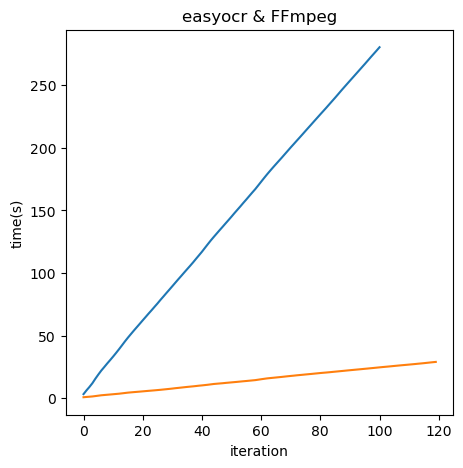

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))
plt.plot(time_CV2)
plt.plot(time_ffmepg)
plt.xlabel('iteration')
plt.ylabel('time(s)')
plt.title('easyocr & FFmpeg')
plt.show()